<h1> Задание:</h1>
Реализовать и обучить Stacked Hourglass Network для поиска ключевых точек лица, а также написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек

![image.png](https://raw.githubusercontent.com/kjw9899/kjw9899.github.io/master/kjw9899/kjw9899.github.io/assets/images/image-20220331201742790.png)

Конкретные задачи:
* Реализовать Hourglass блок
* Реализовать Stacked Hourglass
* Подготовить датасет, преобразовав точки в Heatmap'ы
* Обучить модель
* Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

<h1> Импорт библиотек</h1>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
import torchvision.transforms as transforms

import os

<h1>Hourglass block</h1>

Структура блока:

![image.png](https://i.postimg.cc/fyPxNwn0/images-qsdcfd-post-cac04e49-1042-4492-93fb-bf67f2365fc6-image.png)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

In [ ]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ResidualBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        skip = self.conv(x)
        x = self.pool(skip)
        return x, skip
    

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = ResidualBlock(in_channels, out_channels)
        

    def forward(self, x, skip):
        x = self.upsample(x)
        x = self.conv(x + skip)
        return x
    

In [ ]:
class HourglassBlock(nn.Module):
    def __init__(self, in_channels, features):
        super().__init__()

        self.down_1 = DownSample(in_channels, features)
        self.down_2 = DownSample(features, features * 2)
        self.down_3 = DownSample(features * 2, features * 4)
        self.down_4 = DownSample(features * 4, features * 8)

        self.bottleneck = nn.Sequential(
            ResidualBlock(features * 8, features * 8),
            ResidualBlock(features * 8, features * 8),
            ResidualBlock(features * 8, features * 8)
        )

        self.up_1 = UpSample(features * 8, features * 4)
        self.up_2 = UpSample(features * 4, features * 2)
        self.up_3 = UpSample(features * 2, features)
        self.up_4 = UpSample(features, in_channels)

    def forward(self, x):
        x, skip_1 = self.down_1(x)
        x, skip_2 = self.down_2(x)
        x, skip_3 = self.down_3(x)
        x, skip_4 = self.down_4(x)

        x = self.bottleneck(x)

        x = self.up_1(x, skip_4)
        x = self.up_2(x, skip_3)
        x = self.up_3(x, skip_2)
        x = self.up_4(x, skip_1)
        
        return x

<h1>Stacked Hourglass Network</h1>

Hourglass block реализован, теперь нам надо сделать Stacked Hourglass Network, для этого нам также понадобится сделать голову для предсказывания heatmap'ов

In [ ]:
class Head(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
    
    def forward(self, x):
        return self.head(x)

Выдержка из статьи: 
Illustration of the intermediate supervision process. The network splits and produces a set of heatmaps (outlined in blue) where a loss can be applied. A 1x1 convolution remaps the heatmaps to match the number of channels of the intermediate features. These are added together along with the features from the preceding hourglass
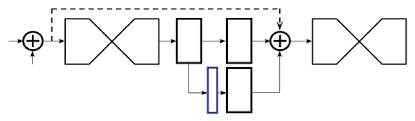

Также выдержка из статьи: After reaching the output resolution of the network, two consecutive rounds of 1x1 convolutions are applied to produce the final network predictions. The output of the network is a set of heatmaps where for a given heatmap the network predicts the probability of a joint’s presence at each and every pixel. 

Получается, по схеме: После hourglass block мы получаем heatmap, используя голову, после этого нужно сделать remap(heatmap) с помощью conv 1x1(я также добавил batchnorm и relu), результат hourglass прогоняем через две свертки 1x1, и на следующую итерацию подаем сумму remap, результата текущей hourglass и результата с предыдущей итерации

In [ ]:
class StackedHourglass(nn.Module):
    def __init__(self, in_channels, features, num_blocks, num_keypoints):
        super().__init__()
        self.num_blocks = num_blocks

        self.hourglass = nn.ModuleList(HourglassBlock(in_channels, features) for _ in range(self.num_blocks))
        self.head = nn.ModuleList(Head(in_channels, num_keypoints) for _ in range(self.num_blocks))

        self.remap = nn.ModuleList(nn.Sequential(
            nn.Conv2d(num_keypoints, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        ) for _ in range(self.num_blocks - 1))

        self.f_i = nn.ModuleList(nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1)
        ) for _ in range(self.num_blocks - 1))

    def forward(self, x):
        outputs = []    # список для хранения heatmap'ов после каждой головы 

        for i in range(self.num_blocks):
            previous_x = x
            x = self.hourglass[i](x)
            heatmap = self.head[i](x) 
            outputs.append(heatmap)
            if i < self.num_blocks - 1:
                x = previous_x + self.remap[i](heatmap) + self.f_i[i](x)

        return outputs

<h1>CelebA</h1>

В торче уже есть celeba, но там уже выровненные фото, поэтому я скачал невыровненные фотки вручную.

In [ ]:
class CelebA(Dataset):
    def __init__(self, root, split='train', transform=None):
    